# 05b — Predictive Model: What Makes a PL Category Leader?

**Objective:** Build a lightweight interpretable model that identifies product attributes correlated with private label success.

## Approach
1. **Label:** PL products in the top 3 by OFF scan count within their category (rough popularity proxy)
2. **Features:** Nutri-Score, NOVA group, nutrient profile, label claims (organic, vegan, etc.)
3. **Model:** Gradient Boosted Trees — kept interpretable for business audience
4. **Key output:** Feature importances — "PL products that lead their categories tend to have X, Y, Z"

## Caveats (stated upfront)
- OFF scans are a noisy proxy for actual sales — selection bias toward products consumers photograph
- Correlations, not causes — a Nutri-Score A label doesn't *cause* success
- Sample: PL products with scan data (~37K products)

In [1]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print('Working directory:', os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

from src.models.success_predictor import (
    prepare_features,
    label_category_leaders,
    build_success_predictor,
)
from src.models.brand_classifier import build_pl_classifier

sns.set_theme(style='whitegrid', palette='colorblind')
os.makedirs('results', exist_ok=True)
print('Imports OK')

Working directory: /Users/joshua/PycharmProjects/PortfolioProjectIdeas/PrivateLabelOpportunities


Imports OK


## 1. Data Preparation

In [2]:
# Load OFF data
df = pd.read_parquet('data/processed/off_eu_clean.parquet')
print(f'Total products: {len(df):,}')

# Filter to products with Nutri-Score + category + scans
mask = (
    df['nutriscore_grade'].isin(['a', 'b', 'c', 'd', 'e'])
    & df['category_l1'].notna()
    & (df['category_l1'] != 'Unknown')
    & df['unique_scans_n'].notna()
    & (df['unique_scans_n'] > 0)
)
df_model = df[mask].copy()
print(f'Products with score + category + scans: {len(df_model):,}')
print(f'  of which PL: {df_model["is_private_label"].sum():,}')
print(f'  of which branded: {(~df_model["is_private_label"]).sum():,}')

Total products: 2,568,269
Products with score + category + scans: 542,233
  of which PL: 82,367
  of which branded: 459,866


In [3]:
# Label PL category leaders (top 3 by scans per category)
df_model['is_category_leader'] = label_category_leaders(df_model, top_n=3)

print(f'PL category leaders: {df_model["is_category_leader"].sum()}')
print(f'Non-leaders: {(~df_model["is_category_leader"]).sum():,}')
print(f'Leader ratio: {df_model["is_category_leader"].mean():.4%}')

PL category leaders: 522
Non-leaders: 541,711
Leader ratio: 0.0963%


In [4]:
# Build feature matrix
features = prepare_features(df_model)
feature_cols = features.columns.tolist()

# Combine features with label
df_ml = features.copy()
df_ml['is_category_leader'] = df_model['is_category_leader'].astype(int)

# Drop rows where all features are NaN
df_ml = df_ml.dropna(subset=feature_cols, how='all')

print(f'Full dataset: {len(df_ml):,} products, {len(feature_cols)} features')
print(f'Leaders: {df_ml["is_category_leader"].sum()}')

# Subsample for tractable training: all leaders + balanced non-leaders
leaders = df_ml[df_ml['is_category_leader'] == 1]
non_leaders = df_ml[df_ml['is_category_leader'] == 0].sample(
    n=min(len(leaders) * 20, 50_000), random_state=42
)
df_ml_train = pd.concat([leaders, non_leaders]).sample(frac=1, random_state=42)

print(f'\nTraining subset: {len(df_ml_train):,} products')
print(f'  Leaders: {df_ml_train["is_category_leader"].sum()}'  )
print(f'  Non-leaders: {(df_ml_train["is_category_leader"] == 0).sum():,}')
print(f'\nFeatures: {feature_cols}')
print(f'\nFeature coverage:')
for col in feature_cols:
    pct = df_ml_train[col].notna().mean()
    print(f'  {col}: {pct:.1%}')

Full dataset: 542,233 products, 17 features
Leaders: 522

Training subset: 10,962 products
  Leaders: 522
  Non-leaders: 10,440

Features: ['energy_kcal_100g', 'sugars_100g', 'saturated_fat_100g', 'salt_100g', 'fiber_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'sodium_100g', 'nutriscore_ordinal', 'nova_group', 'is_organic', 'is_vegan', 'is_vegetarian', 'is_gluten_free', 'n_labels', 'nutriscore_computed']

Feature coverage:
  energy_kcal_100g: 95.2%
  sugars_100g: 98.0%
  saturated_fat_100g: 97.9%
  salt_100g: 98.3%
  fiber_100g: 47.8%
  proteins_100g: 98.1%
  fat_100g: 98.0%
  carbohydrates_100g: 98.0%
  sodium_100g: 98.3%
  nutriscore_ordinal: 100.0%
  nova_group: 65.3%
  is_organic: 100.0%
  is_vegan: 100.0%
  is_vegetarian: 100.0%
  is_gluten_free: 100.0%
  n_labels: 100.0%
  nutriscore_computed: 100.0%


## 2. Success Predictor: Gradient Boosted Trees

In [5]:
# Train the model on balanced subsample
model, importances, cv_scores = build_success_predictor(
    df_ml_train, feature_cols, label_col='is_category_leader'
)

print(f'Cross-validated AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})')
print(f'\nFeature Importances:')
display(importances.round(4))

Cross-validated AUC: 0.653 (+/- 0.039)

Feature Importances:


,feature,importance
4,fiber_100g,0.1140
5,proteins_100g,0.1107
2,saturated_fat_100g,0.1043
0,energy_kcal_100g,0.0937
7,carbohydrates_100g,0.0934
1,sugars_100g,0.0841
6,fat_100g,0.0809
8,sodium_100g,0.0762
15,n_labels,0.0621
9,nutriscore_ordinal,0.0475


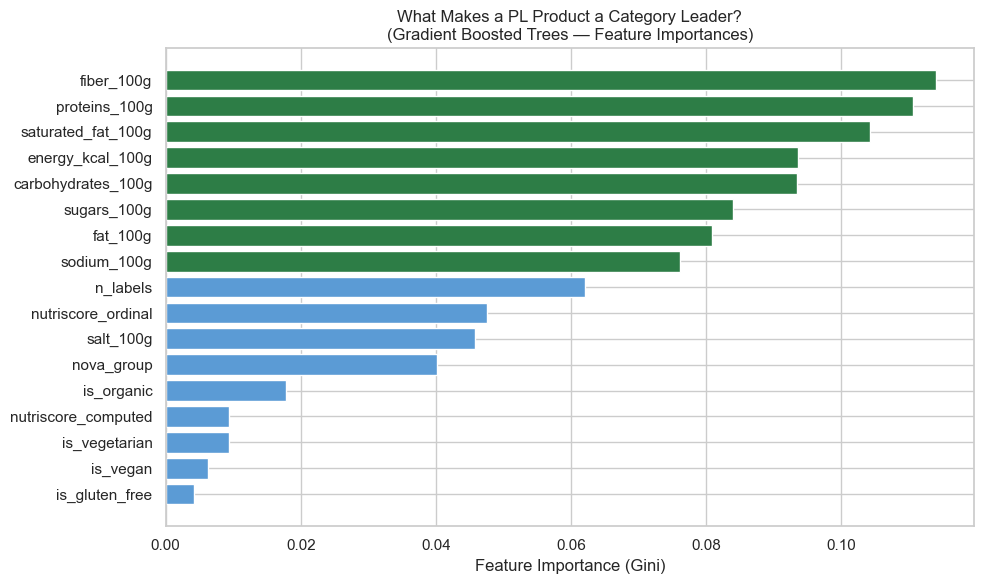

Saved: results/feature_importances.png


In [6]:
# Visualise feature importances
fig, ax = plt.subplots(figsize=(10, 6))
imp = importances.sort_values('importance')
colors = ['#2d7d46' if v > imp['importance'].median() else '#5b9bd5' for v in imp['importance']]
ax.barh(imp['feature'], imp['importance'], color=colors)
ax.set_xlabel('Feature Importance (Gini)')
ax.set_title('What Makes a PL Product a Category Leader?\n(Gradient Boosted Trees — Feature Importances)')
plt.tight_layout()
plt.savefig('results/feature_importances.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/feature_importances.png')

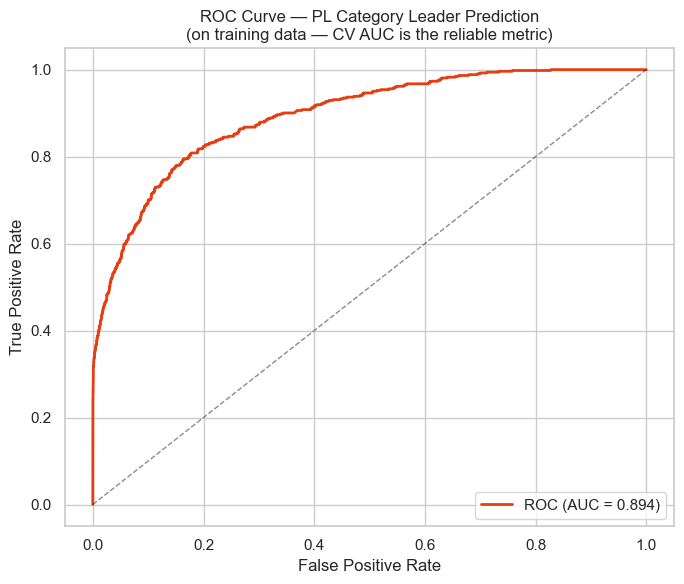

Saved: results/roc_curve_success.png


In [7]:
# ROC curve on training data
X_all = df_ml_train[feature_cols].fillna(0)
y_all = df_ml_train['is_category_leader']
y_prob = model.predict_proba(X_all)[:, 1]

fpr, tpr, _ = roc_curve(y_all, y_prob)
auc_val = roc_auc_score(y_all, y_prob)

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(fpr, tpr, color='#e63e11', lw=2, label=f'ROC (AUC = {auc_val:.3f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve — PL Category Leader Prediction\n(on training data — CV AUC is the reliable metric)')
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('results/roc_curve_success.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/roc_curve_success.png')

## 3. Profile of PL Leaders vs Non-Leaders

Beyond the model, compare the actual attribute distributions to make the story concrete.

In [8]:
# Compare leaders vs non-leaders on key attributes
leader_mask = df_model['is_category_leader'] == True
pl_mask = df_model['is_private_label'] == True

compare_cols = ['nutriscore_grade', 'sugars_100g', 'saturated_fat_100g',
                'salt_100g', 'fiber_100g', 'proteins_100g', 'energy_kcal_100g']

print('PL Leaders vs All PL Products:\n')
for col in compare_cols:
    if col == 'nutriscore_grade':
        # Show % A/B
        leader_ab = df_model.loc[leader_mask, col].isin(['a', 'b']).mean()
        all_pl_ab = df_model.loc[pl_mask, col].isin(['a', 'b']).mean()
        all_ab = df_model[col].isin(['a', 'b']).mean()
        print(f'  % A/B grades:')
        print(f'    PL Leaders: {leader_ab:.1%}')
        print(f'    All PL:     {all_pl_ab:.1%}')
        print(f'    All prods:  {all_ab:.1%}')
    else:
        leader_med = df_model.loc[leader_mask, col].median()
        all_pl_med = df_model.loc[pl_mask, col].median()
        all_med = df_model[col].median()
        print(f'  {col}:')
        print(f'    PL Leaders: {leader_med:.1f}')
        print(f'    All PL:     {all_pl_med:.1f}')
        print(f'    All prods:  {all_med:.1f}')
    print()

PL Leaders vs All PL Products:

  % A/B grades:
    PL Leaders: 28.9%
    All PL:     29.6%
    All prods:  27.8%

  sugars_100g:
    PL Leaders: 2.8
    All PL:     3.3
    All prods:  3.6

  saturated_fat_100g:
    PL Leaders: 1.7
    All PL:     1.8
    All prods:  1.9

  salt_100g:
    PL Leaders: 0.8
    All PL:     0.5
    All prods:  0.4

  fiber_100g:
    PL Leaders: 1.5
    All PL:     1.6
    All prods:  1.9

  proteins_100g:
    PL Leaders: 5.9
    All PL:     6.1
    All prods:  6.0



  energy_kcal_100g:
    PL Leaders: 237.0
    All PL:     229.0
    All prods:  253.0



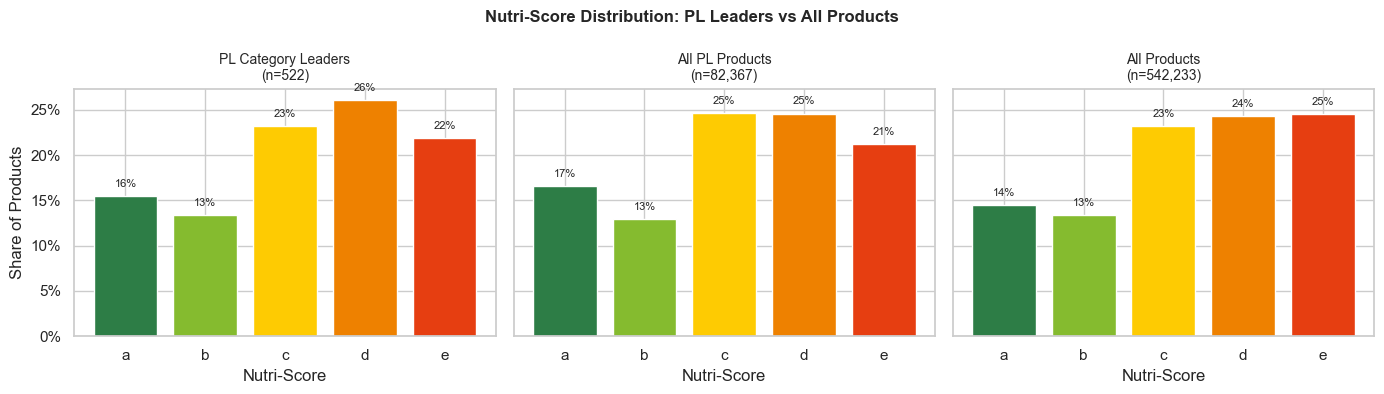

Saved: results/leader_nutriscore_comparison.png


In [9]:
# Nutri-Score grade distribution: Leaders vs All PL vs All products
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

grade_order = ['a', 'b', 'c', 'd', 'e']
grade_colors = ['#2d7d46', '#85bb2f', '#fecb02', '#ee8100', '#e63e11']

for ax, (label, subset) in zip(axes, [
    ('PL Category Leaders', df_model[leader_mask]),
    ('All PL Products', df_model[pl_mask]),
    ('All Products', df_model),
]):
    dist = subset['nutriscore_grade'].value_counts(normalize=True)
    vals = [dist.get(g, 0) for g in grade_order]
    ax.bar(grade_order, vals, color=grade_colors)
    ax.set_title(f'{label}\n(n={len(subset):,})', fontsize=10)
    ax.set_xlabel('Nutri-Score')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    for i, v in enumerate(vals):
        ax.text(i, v + 0.01, f'{v:.0%}', ha='center', fontsize=8)

axes[0].set_ylabel('Share of Products')
fig.suptitle('Nutri-Score Distribution: PL Leaders vs All Products', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('results/leader_nutriscore_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/leader_nutriscore_comparison.png')

## 4. Brand Classifier: PL Detection from Brand Name

A secondary model: can we detect private label products just from the brand name string? This uses TF-IDF character n-grams + logistic regression.

Practical use: catch PL products that our brand dictionary missed.

In [10]:
# Train brand classifier on products with known PL status and non-empty brands
has_brand = df['brand_clean'].notna() & (df['brand_clean'] != '')
df_brand = df[has_brand].copy()

# Balanced sample: take all PL + equal number of branded, capped at 50K each
pl_brand = df_brand[df_brand['is_private_label']].sample(n=min(len(df_brand[df_brand['is_private_label']]), 50_000), random_state=42)
branded = df_brand[~df_brand['is_private_label']].sample(n=min(len(pl_brand), 50_000), random_state=42)
df_train = pd.concat([pl_brand, branded]).sample(frac=1, random_state=42)

print(f'Training brand classifier on {len(df_train):,} products')
print(f'  PL: {df_train["is_private_label"].sum():,}')
print(f'  Branded: {(~df_train["is_private_label"]).sum():,}')

classifier = build_pl_classifier(df_train, text_col='brand_clean', label_col='is_private_label')

# Cross-validation scores
from sklearn.model_selection import cross_val_score
cv_f1 = cross_val_score(classifier, df_train['brand_clean'].fillna(''), 
                         df_train['is_private_label'].astype(int), cv=5, scoring='f1')
print(f'\nBrand classifier CV F1: {cv_f1.mean():.3f} (+/- {cv_f1.std():.3f})')

Training brand classifier on 100,000 products
  PL: 50,000
  Branded: 50,000



Brand classifier CV F1: 0.996 (+/- 0.001)


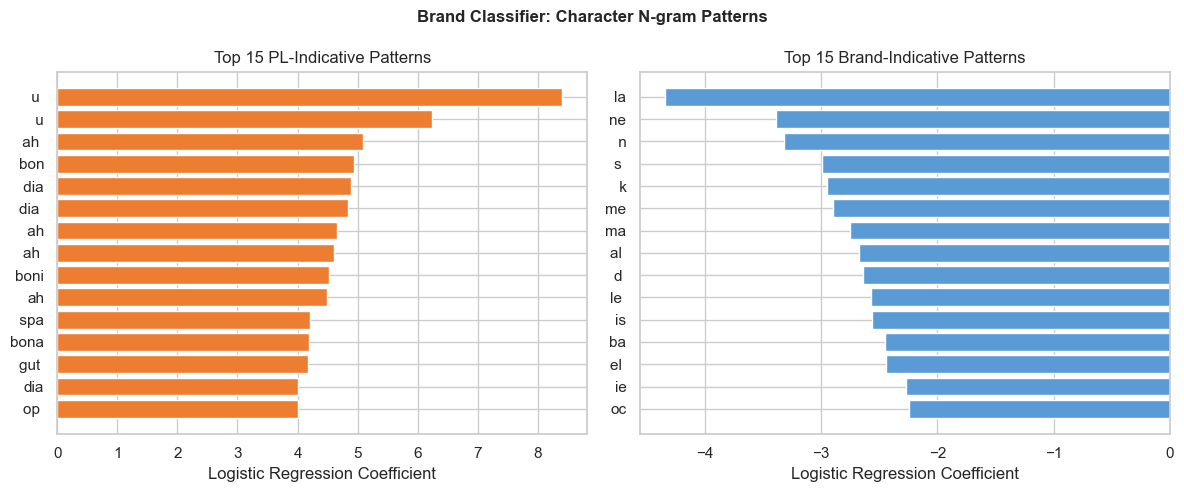

Saved: results/brand_classifier_features.png


In [11]:
# Show top PL-indicative and brand-indicative features
tfidf = classifier.named_steps['tfidf']
clf = classifier.named_steps['clf']
feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_[0]

top_pl = pd.Series(coefs, index=feature_names).nlargest(15)
top_brand = pd.Series(coefs, index=feature_names).nsmallest(15)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
top_pl_sorted = top_pl.sort_values()
ax.barh(top_pl_sorted.index, top_pl_sorted.values, color='#ed7d31')
ax.set_title('Top 15 PL-Indicative Patterns')
ax.set_xlabel('Logistic Regression Coefficient')

ax = axes[1]
top_brand_sorted = top_brand.sort_values(ascending=False)
ax.barh(top_brand_sorted.index, top_brand_sorted.values, color='#5b9bd5')
ax.set_title('Top 15 Brand-Indicative Patterns')
ax.set_xlabel('Logistic Regression Coefficient')

fig.suptitle('Brand Classifier: Character N-gram Patterns', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('results/brand_classifier_features.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/brand_classifier_features.png')

## Key Findings

**Success Predictor:**
- Feature importances reveal which product attributes correlate with PL category leadership
- The model is deliberately simple (interpretability over accuracy)
- Key caveat: OFF scan counts are a noisy popularity proxy

**Brand Classifier:**
- Character n-gram patterns in brand names are highly predictive of PL status
- Can be used to catch PL products our dictionary-based approach missed

These insights complement the opportunity scoring in Notebook 05 — the model tells us not just *where* to launch PL, but *what kind* of product tends to succeed.